### imports 

In [1]:
if 'google.colab' in str(get_ipython()):
    remote_flag = 1
    !pip install mnist
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    remote_flag = 0
    from six.moves import urllib    
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)

import ModuleGenFlow as genflow
import operationUtils as op
import mnist
import numpy as np
import pickle
import time

from matplotlib import pyplot as plt
from matplotlib import colors
import torchvision.datasets.cifar as cifar

### data preprocessing

In [2]:
from torchvision import datasets
new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
datasets.MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in datasets.MNIST.resources
]
train_dataset = datasets.MNIST(
   "./data", train=True, download=True)
x_train = train_dataset.train_data.numpy()
y_train = train_dataset.train_labels.numpy()

Failed to download (trying next):
HTTP Error 524: 

Failed to download (trying next):
HTTP Error 404: Not Found



RuntimeError: Error downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz

In [5]:
choose_mnist_cifar = 0 # 0 = mnist, 1 = cifar
cifar_labels_reduction = [3, 4, 5, 6]
n_per_label = 1000

if choose_mnist_cifar == 0: # MNIST
    n_channel = 1
    dataset_path = F"MNIST/"
    x_train = mnist.train_images()
    y_train = mnist.train_labels()
    labels = np.unique(y_train)
    x_train_sampled = np.zeros([len(labels)*n_per_label, x_train.shape[1],x_train.shape[2]])
    ### equaly sample labels ###
    for k in labels:
        curr_label_data = x_train[(y_train == k),:,:]
        sample_idcs = np.random.choice(np.arange(curr_label_data.shape[0]), n_per_label, replace=False)
        samples_per_label = curr_label_data[sample_idcs,:,:]
        x_train_sampled[k*n_per_label:(k+1)*n_per_label, :,:] = samples_per_label
else: # CIFAR
    n_channel = 3
    dataset_path = F"CIFAR/"
    cifar_trainset = cifar.CIFAR10(root='./data', train=True, download=True, transform=None)
    x_train = cifar_trainset.data
    y_train = np.array(cifar_trainset.targets)
    labels = cifar_labels_reduction
    x_train_sampled = np.zeros([len(labels)*n_per_label, x_train.shape[1],x_train.shape[2], x_train.shape[3]])

    for k in range(len(labels)):
        curr_label_data = x_train[(y_train == labels[k]),:,:,:]
        sample_idcs = np.random.choice(np.arange(curr_label_data.shape[0]), n_per_label, replace=False)
        samples_per_label = curr_label_data[sample_idcs,:,:,:]
        x_train_sampled[k*n_per_label:(k+1)*n_per_label, :,:,:] = samples_per_label


del x_train
del y_train


## Choose model architecture

In [6]:
# set num of model latent samples
n_samples = 1000 # max 10000
# create empty model object
model = genflow.GenFlow(n_gen_samples=n_samples)
# set architecture
arch = 6 # 1, 2, 3, 4

## Architecture 1 - "Original"

In [13]:
if arch == 1:

  # scale 7x7
  model.add_layer(genflow.Linear(features_dim=7*7*n_channel, poly_deg=5, n_iter=2, use_multiprocessing=0))
  model.add_layer(genflow.Conv(features_dim=7*7*n_channel, kernel_dim=5, poly_deg=4, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=7*7*n_channel, kernel_dim=3, poly_deg=3, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))

  # scale 14x14
  model.add_layer(genflow.Linear(features_dim=14*14*n_channel, poly_deg=6, n_iter=2, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=14*14*n_channel, kernel_dim=7, poly_deg=5, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=14*14*n_channel, kernel_dim=5, poly_deg=4, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))

  # scale 21x21
  model.add_layer(genflow.Linear(features_dim=21*21*n_channel, poly_deg=7, n_iter=2, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=21*21*n_channel, kernel_dim=7, poly_deg=5, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=21*21*n_channel, kernel_dim=5, poly_deg=4, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=21*21*n_channel, kernel_dim=3, poly_deg=3, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))

  # scale 28x28
  model.add_layer(genflow.Linear(features_dim=28*28*n_channel, poly_deg=6, n_iter=2, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=28*28*n_channel, kernel_dim=7, poly_deg=5, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=28*28*n_channel, kernel_dim=5, poly_deg=4, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))
  model.add_layer(genflow.Conv(features_dim=28*28*n_channel, kernel_dim=3, poly_deg=3, n_iter=2, is_rgb=choose_mnist_cifar, use_multiprocessing=1))

  scales_sizes = (3, 3, 4, 4)

## Architecture 2 - fully linear Long

In [14]:
if arch == 2:

  # scale 7x7
  model.add_layer(genflow.Linear(features_dim=7*7*n_channel, poly_deg=5, n_iter=1000))

  # scale 14x14
  model.add_layer(genflow.Linear(features_dim=14*14*n_channel, poly_deg=6, n_iter=1000))

  # scale 21x21
  model.add_layer(genflow.Linear(features_dim=21*21*n_channel, poly_deg=7, n_iter=800))

  # scale 28x28
  model.add_layer(genflow.Linear(features_dim=28*28*n_channel, poly_deg=6, n_iter=600))

  scales_sizes = (1, 1, 1, 1)

## Architecture 3 - fully Conv

In [15]:
if arch == 3:

  # scale 7x7
  model.add_layer(genflow.Conv(features_dim=7*7, kernel_dim=5, poly_deg=4, n_iter=200, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=7*7, kernel_dim=3, poly_deg=3, n_iter=200, is_rgb=choose_mnist_cifar))

  # scale 14x14
  model.add_layer(genflow.Conv(features_dim=14*14, kernel_dim=7, poly_deg=5, n_iter=200, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=14*14, kernel_dim=5, poly_deg=4, n_iter=200, is_rgb=choose_mnist_cifar))

  # scale 21x21
  model.add_layer(genflow.Conv(features_dim=21*21, kernel_dim=7, poly_deg=5, n_iter=200, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=21*21, kernel_dim=5, poly_deg=4, n_iter=200, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=21*21, kernel_dim=3, poly_deg=3, n_iter=200, is_rgb=choose_mnist_cifar))

  # scale 28x28
  model.add_layer(genflow.Conv(features_dim=28*28, kernel_dim=7, poly_deg=5, n_iter=200, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=28*28, kernel_dim=5, poly_deg=4, n_iter=200, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=28*28, kernel_dim=3, poly_deg=3, n_iter=200, is_rgb=choose_mnist_cifar))

  scales_sizes = (2, 2, 3, 3)

## Architecture 4 - combined, Conv Short

In [16]:
if arch == 4:
  # scale 7x7
  model.add_layer(genflow.Linear(features_dim=7*7*n_channel, poly_deg=5, n_iter=400))
  model.add_layer(genflow.Conv(features_dim=7*7*n_channel, kernel_dim=5, poly_deg=4, n_iter=50, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=7*7*n_channel, kernel_dim=3, poly_deg=3, n_iter=50, is_rgb=choose_mnist_cifar))

  # scale 14x14
  model.add_layer(genflow.Linear(features_dim=14*14*n_channel, poly_deg=6, n_iter=400))
  model.add_layer(genflow.Conv(features_dim=14*14*n_channel, kernel_dim=7, poly_deg=5, n_iter=50, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=14*14*n_channel, kernel_dim=5, poly_deg=4, n_iter=50, is_rgb=choose_mnist_cifar))

  # scale 21x21
  model.add_layer(genflow.Linear(features_dim=21*21*n_channel, poly_deg=7, n_iter=200))
  model.add_layer(genflow.Conv(features_dim=21*21*n_channel, kernel_dim=7, poly_deg=5, n_iter=50, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=21*21*n_channel, kernel_dim=5, poly_deg=4, n_iter=50, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=21*21*n_channel, kernel_dim=3, poly_deg=3, n_iter=50, is_rgb=choose_mnist_cifar))

  # scale 28x28
  model.add_layer(genflow.Linear(features_dim=28*28*n_channel, poly_deg=6, n_iter=200))
  model.add_layer(genflow.Conv(features_dim=28*28*n_channel, kernel_dim=7, poly_deg=5, n_iter=50, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=28*28*n_channel, kernel_dim=5, poly_deg=4, n_iter=50, is_rgb=choose_mnist_cifar))
  model.add_layer(genflow.Conv(features_dim=28*28*n_channel, kernel_dim=3, poly_deg=3, n_iter=50, is_rgb=choose_mnist_cifar))

  scales_sizes = (3, 3, 4, 4)

## Architecture 5 - light

In [ ]:
if choose_mnist_cifar:
    n_pixels_per_channel = 32*32
else:
    n_pixels_per_channel = 28*28
if arch == 5:
    model.add_layer(genflow.Linear(features_dim=n_pixels_per_channel*n_channel, poly_deg=6, n_iter=500, use_multid))
    model.add_layer(genflow.Conv(features_dim=n_pixels_per_channel*n_channel, kernel_dim=7, poly_deg=5, n_iter=200, is_rgb=choose_mnist_cifar))
    model.add_layer(genflow.Conv(features_dim=n_pixels_per_channel*n_channel, kernel_dim=5, poly_deg=4, n_iter=200, is_rgb=choose_mnist_cifar))
    model.add_layer(genflow.Conv(features_dim=n_pixels_per_channel*n_channel, kernel_dim=3, poly_deg=3, n_iter=200, is_rgb=choose_mnist_cifar))

    scales_sizes = (4, )

## Architecture 6 - light

In [4]:
if choose_mnist_cifar:
    n_pixels_per_channel = 32*32
else:
    n_pixels_per_channel = 28*28
if arch == 6:
    model.add_layer(genflow.Linear(features_dim=int(n_pixels_per_channel/16)*n_channel, poly_deg=6, n_iter=500))
    model.add_layer(genflow.Linear(features_dim=int(n_pixels_per_channel/4)*n_channel, poly_deg=6, n_iter=500))
    model.add_layer(genflow.Linear(features_dim=n_pixels_per_channel*n_channel, poly_deg=6, n_iter=500))


    scales_sizes = (3, )

## Run *GenFlow*

In [4]:
if remote_flag:
    w_dir = F"/content/gdrive/My Drive/Colab Notebooks/genFlow/"
else:
    w_dir = F"C:/Users/elada/OneDrive - Technion/projB_SIPL/Data/"

w_dir = w_dir + dataset_path

if arch == 1:
  path = w_dir + F"original/"
elif arch == 2:
  path = w_dir + F"linear/"
elif arch == 3:
  path = w_dir + F"conv/"
elif arch == 4:
  path = w_dir + F"combined/"
elif arch == 5:
  path = w_dir + F"light/"
elif arch == 6:
  path = w_dir + F"orth_check/"
data_path = path + F"data_input"

with open(data_path, 'wb') as file:
  pickle.dump(x_train_sampled, file)
n_layers = model.get_num_of_layers()
curr_scale = 0
k = 0
for i in range(n_layers):
    start_time = time.time()
    if i == 0:
        p_gen = model.fit(x_train_sampled, start_layer=i, last_layer_idx=i)
    else:
        p_gen = model.fit(x_train_sampled, p_gen, start_layer=i, last_layer_idx=i)
    end_time = time.time()
    k = k + 1
    if k == (scales_sizes[curr_scale]):
        fname = 'genFlow_scale_' + str(curr_scale+1)
        fname_2 = 'gen_output_scale_' + str(curr_scale+1)

        model_path = path + F"{fname}"
        gen_output_path = path + F"{fname_2}"

        with open(model_path, 'wb') as file:
            pickle.dump(model, file)
        with open(gen_output_path, 'wb') as file:
            pickle.dump(p_gen, file)
        k = 0 
        curr_scale = curr_scale + 1

NameError: name 'dataset_path' is not defined

In [5]:
### run from middle option ###
if remote_flag:
    w_dir = F"/content/gdrive/My Drive/Colab Notebooks/genFlow/"
else:
    w_dir = F"C:/Users/elada/OneDrive - Technion/projB_SIPL/Data/"

w_dir = w_dir + dataset_path
path = w_dir + F"orth_check/"

data_path = path + F"data_input"
#model_path = path + F"genFlow_scale_3"
#gen_output_path = path + F"gen_output_scale_3"

with open(data_path, 'rb') as file:
    x_train_sampled = pickle.load(file) 
#with open(model_path, 'rb') as file:
#    model = pickle.load(file)
#with open(gen_output_path, 'rb') as file:
#    p_gen = pickle.load(file)

scales_sizes = (3,)
curr_scale = 0
k = 0
remain_iters = np.arange(model.get_last_exec_layer()+1, model.get_num_of_layers())

for i in remain_iters:
  p_gen = model.fit(x_train_sampled, start_layer=i, last_layer_idx=i)
  k = k + 1
  if k == (scales_sizes[curr_scale]):
      fname = 'genFlow_scale_' + str(curr_scale+1)
      fname_2 = 'gen_output_scale_' + str(curr_scale+1)
      model_path = path + F"{fname}"
      gen_output_path = path + F"{fname_2}"

      with open(model_path, 'wb') as file:
        pickle.dump(model, file)
      with open(gen_output_path, 'wb') as file:
        pickle.dump(p_gen, file)
      k = 0 
      curr_scale = curr_scale + 1


finished fit for Layer: 0, time elapsed: 26.521
finished fit for Layer: 1, time elapsed: 112.393
finished fit for Layer: 2, time elapsed: 574.302


# Load trained model & show results

In [13]:
if remote_flag:
    w_dir = F"/content/gdrive/My Drive/Colab Notebooks/genFlow/"
else:
    w_dir = F"C:/Users/elada/OneDrive - Technion/projB_SIPL/Data/"

w_dir = w_dir + dataset_path

data_path = w_dir + F"orth_check/data_input"

path = w_dir + F"orth_check/genFlow_scale_1"
gen_output_path = w_dir + F"orth_check/gen_output_scale_1"
with open(data_path, 'rb') as file:
    p_data = pickle.load(file) 
with open(path, 'rb') as file:
    model = pickle.load(file) 
with open(gen_output_path, 'rb') as file:
    p_gen = pickle.load(file) 


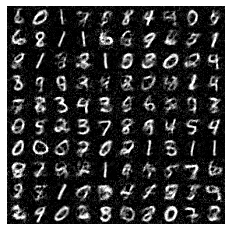

In [15]:
p_gen_data = op.flatten_and_fit_dims(p_gen)
collage = op.convert_data_to_collage(p_gen_data)
#fig = plt.figure(figsize=(12,12))
#plt.imshow(collage, cmap=plt.cm.gray, norm=colors.Normalize(), vmin = 0, vmax = 255)
plt.imshow(collage/255, norm=colors.Normalize(vmin=0, vmax=1), cmap='gray')
plt.axis('off')

plt.show()

In [9]:
amount = 100
gen_samples = model.transform(x_train_sampled, amount)


finished transforming at Layer: 0, time elapsed: 3.672
finished transforming at Layer: 1, time elapsed: 9.057
finished transforming at Layer: 2, time elapsed: 82.972


<ipython-input-18-a86ec2fb16f9>:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(collage, cmap=plt.cm.gray, norm=colors.Normalize(), vmin = 0, vmax = 255)


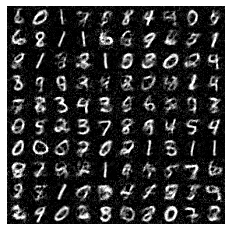

In [18]:

plt.imshow(collage, cmap=plt.cm.gray, norm=colors.Normalize(), vmin = 0, vmax = 255)
plt.axis('off')

plt.savefig(w_dir + F"orth_check/examp1")
#for i in range(amount):#np.random.choice(amount, 10):
#  plt.imshow(gen_samples[i, :, :], cmap=plt.cm.gray, norm=colors.Normalize(), vmin = 0, vmax = 255)
#  plt.axis('off')
#  plt.show()


In [ ]:
layers=model.get_layer_list()
lay1 = layers[0]
mat_list = lay1.get_proj_mat_list()
p_data_op = op.flatten_and_fit_dims(p_data)
C = np.cov(p_data_op)
w1 = op.gen_orthogonal_mat(p_data_op, C, random_state=mat_list[0])
w2 = op.gen_orthogonal_mat(p_data_op, C, random_state=mat_list[0])

p_data_rsz1 = lay1.data_size_fit(p_data)
p_data_rsz2 = lay1.data_size_fit(p_data)
np.all(p_data_rsz1 == p_data_rsz2)
#p_data_resize_1.shape

In [ ]:
plt.imshow(gen_samples[2,:,:], cmap=plt.cm.gray, norm=colors.Normalize(), vmin = 0, vmax = 255)
plt.show()

NameError: name 'model_path' is not defined